In [1]:
import numpy as np
from collections import defaultdict

import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

import heapq

import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import pandas as pd

from tqdm import tqdm
import cv2

In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
data_df = pd.read_csv('generated_images/data.csv')
data_df

,num_shapes,shape_0,color_0,position_0,filename,shape_1,color_1,position_1,shape_2,color_2,position_2,shape_3,color_3,position_3,shape_4,color_4,position_4
0,1,pentagon,red,BL,generated_images/image_1_shapes_0.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pentagon,red,BR,generated_images/image_1_shapes_1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,square,red,TR,generated_images/image_1_shapes_2.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,hexagon,black,M,generated_images/image_1_shapes_3.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,square,blue,M,generated_images/image_1_shapes_4.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,pentagon,blue,BR,generated_images/image_5_shapes_95.png,triangle,black,BL,hexagon,yellow,M,square,green,TL,circle,pink,TR
496,5,pentagon,pink,BR,generated_images/image_5_shapes_96.png,hexagon,yellow,BL,circle,red,TL,square,blue,M,triangle,green,TR
497,5,triangle,blue,M,generated_images/image_5_shapes_97.png,hexagon,pink,BR,circle,green,TL,pentagon,red,TR,square,yellow,BL
498,5,square,yellow,BL,generated_images/image_5_shapes_98.png,hexagon,red,BR,triangle,pink,TL,circle,blue,M,pentagon,black,TR


In [4]:
activations_df = pd.read_csv('generated_images/clip_mlp_activations.csv')
activations_df

,filename,mean_0_0,max_0_0,mean_0_1,max_0_1,mean_0_2,max_0_2,mean_0_3,max_0_3,mean_0_4,...,mean_23_1019,max_23_1019,mean_23_1020,max_23_1020,mean_23_1021,max_23_1021,mean_23_1022,max_23_1022,mean_23_1023,max_23_1023
0,generated_images/image_1_shapes_0.png,0.099164,0.257024,0.298203,0.333471,0.059541,0.090624,0.108643,0.212754,0.022055,...,-0.171294,0.034744,0.227626,0.437658,-0.130334,0.179163,-0.228286,0.008854,-0.119478,0.226579
1,generated_images/image_1_shapes_1.png,0.098868,0.236394,0.298659,0.333518,0.059578,0.093828,0.108109,0.198275,0.022334,...,-0.159002,0.128170,0.228707,0.454122,-0.121280,0.225495,-0.221970,0.040223,-0.119355,0.224534
2,generated_images/image_1_shapes_2.png,0.098371,0.198219,0.294899,0.335975,0.057270,0.078525,0.102543,0.166103,0.021096,...,-0.183971,0.081780,0.185437,0.404024,-0.099349,0.141499,-0.227266,-0.016253,-0.099449,0.229580
3,generated_images/image_1_shapes_3.png,0.105667,0.350031,0.310025,0.336265,0.058159,0.078626,0.111158,0.305242,0.023447,...,-0.175808,0.136730,0.170698,0.396673,-0.065466,0.173172,-0.210550,0.142581,-0.052900,0.315388
4,generated_images/image_1_shapes_4.png,0.102984,0.147678,0.304164,0.331992,0.063006,0.108819,0.106660,0.195209,0.021967,...,-0.175748,0.019588,0.204655,0.394590,-0.124101,0.192931,-0.233677,-0.016928,-0.109357,0.350109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,generated_images/image_5_shapes_95.png,0.102451,0.214196,0.264764,0.334364,0.047601,0.123497,0.108762,0.324152,0.021233,...,-0.142009,0.198176,0.214031,0.480671,-0.096051,0.227638,-0.217189,0.180153,-0.043028,0.357173
496,generated_images/image_5_shapes_96.png,0.099824,0.218822,0.254907,0.332797,0.048234,0.107941,0.103577,0.216401,0.023336,...,-0.147976,0.131034,0.200914,0.431632,-0.085056,0.267447,-0.210242,0.221128,-0.054774,0.284328
497,generated_images/image_5_shapes_97.png,0.099764,0.249264,0.256887,0.336022,0.047266,0.098838,0.109927,0.263641,0.019197,...,-0.151952,0.087928,0.201548,0.435799,-0.080965,0.278892,-0.212384,0.200994,-0.059827,0.318426
498,generated_images/image_5_shapes_98.png,0.101962,0.418774,0.262032,0.412612,0.047812,0.127314,0.110888,0.263006,0.021316,...,-0.147790,0.160468,0.201102,0.431684,-0.064188,0.318274,-0.208776,0.170633,-0.040669,0.427834


In [5]:
neuron_characteristics_df = pd.read_csv('generated_images/clip_mlp_neuron_characteristics_mean_top_30_last_5_layers.csv')
neuron_characteristics_df

,avg_num_shapes,avg_circle,avg_square,avg_triangle,avg_pentagon,avg_hexagon,avg_red,avg_green,avg_blue,avg_yellow,avg_pink,avg_black,avg_M,avg_TL,avg_TR,avg_BL,avg_BR,neuron_name,entropy
0,1.266667,0.166667,0.400000,0.033333,0.466667,0.200000,0.200000,0.200000,0.066667,0.100000,0.133333,0.566667,0.000000,0.133333,0.033333,0.300000,0.800000,mean_14_0,3.453314
1,1.033333,0.300000,0.033333,0.133333,0.500000,0.066667,0.133333,0.033333,0.033333,0.300000,0.266667,0.266667,0.133333,0.133333,0.000000,0.400000,0.366667,mean_14_1,3.542005
2,4.300000,0.900000,0.966667,0.933333,0.633333,0.866667,0.666667,0.666667,0.800000,0.566667,0.700000,0.900000,0.966667,0.933333,0.800000,0.733333,0.866667,mean_14_2,3.982080
3,1.066667,0.233333,0.033333,0.033333,0.433333,0.333333,0.133333,0.266667,0.166667,0.266667,0.233333,0.000000,0.500000,0.233333,0.100000,0.066667,0.166667,mean_14_3,3.617702
4,1.400000,0.566667,0.000000,0.733333,0.033333,0.066667,0.133333,0.333333,0.233333,0.233333,0.200000,0.266667,0.500000,0.100000,0.133333,0.333333,0.333333,mean_14_4,3.585032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,4.233333,0.800000,0.900000,0.833333,0.900000,0.800000,0.700000,0.433333,0.800000,0.933333,0.666667,0.700000,1.000000,0.800000,0.800000,0.833333,0.800000,mean_23_1019,3.980404
10236,1.966667,0.633333,0.333333,0.366667,0.400000,0.233333,0.133333,0.166667,0.200000,0.800000,0.433333,0.233333,0.433333,0.433333,0.400000,0.300000,0.400000,mean_23_1020,3.861107
10237,3.766667,0.700000,1.000000,0.700000,0.633333,0.733333,0.633333,0.500000,0.500000,0.433333,0.700000,1.000000,0.700000,0.600000,0.766667,0.766667,0.933333,mean_23_1021,3.962788
10238,4.300000,0.966667,0.833333,0.733333,0.900000,0.866667,0.666667,0.666667,0.766667,0.700000,0.666667,0.833333,0.900000,0.833333,0.833333,0.800000,0.933333,mean_23_1022,3.990011


In [6]:
neuron_characteristics_df.entropy.describe()

count    10240.000000
mean         3.829802
std          0.164058
min          3.258612
25%          3.710909
50%          3.897137
75%          3.969178
max          3.994179
Name: entropy, dtype: float64

In [7]:
from vit_prisma.models.base_vit import HookedViT

e:\Anaconda\envs\acv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_name = "openai/clip-vit-large-patch14"

In [9]:
model_hooked = HookedViT.from_pretrained(model_name, is_clip=True, is_timm=False)

Official model name openai/clip-vit-large-patch14
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model openai/clip-vit-large-patch14 into HookedTransformer


In [10]:
def get_top_features(neuron_characteristics_df, neuron_name, top_k=3):
    neuron_row = neuron_characteristics_df[neuron_characteristics_df['neuron_name'] == neuron_name].iloc[0]
    neuron_key_values = [(key, neuron_row[key]) for key in neuron_row.keys() if key not in ['neuron_name', 'entropy', 'avg_num_shapes']]
    neuron_key_values = sorted(neuron_key_values, key=lambda x: x[1], reverse=True)
    neuron_key_values = [(x[0].replace("avg_", ""), x[1]) for x in neuron_key_values]
    return neuron_key_values[:top_k]

In [11]:
get_top_features(neuron_characteristics_df, 'mean_16_563', top_k=100)

[('circle', np.float64(0.5666666666666667)),
 ('pink', np.float64(0.5666666666666667)),
 ('square', np.float64(0.5333333333333333)),
 ('TL', np.float64(0.4)),
 ('red', np.float64(0.3)),
 ('TR', np.float64(0.2)),
 ('BR', np.float64(0.2)),
 ('M', np.float64(0.1666666666666666)),
 ('BL', np.float64(0.1666666666666666)),
 ('black', np.float64(0.1)),
 ('blue', np.float64(0.0666666666666666)),
 ('yellow', np.float64(0.0666666666666666)),
 ('triangle', np.float64(0.0333333333333333)),
 ('green', np.float64(0.0333333333333333)),
 ('pentagon', np.float64(0.0)),
 ('hexagon', np.float64(0.0))]

In [12]:
get_top_features(neuron_characteristics_df, 'mean_17_774', top_k=100)

[('circle', np.float64(0.9)),
 ('pink', np.float64(0.4666666666666667)),
 ('TL', np.float64(0.4)),
 ('M', np.float64(0.3333333333333333)),
 ('red', np.float64(0.2333333333333333)),
 ('yellow', np.float64(0.2333333333333333)),
 ('square', np.float64(0.1666666666666666)),
 ('TR', np.float64(0.1666666666666666)),
 ('BL', np.float64(0.1666666666666666)),
 ('green', np.float64(0.1333333333333333)),
 ('blue', np.float64(0.0666666666666666)),
 ('BR', np.float64(0.0666666666666666)),
 ('pentagon', np.float64(0.0333333333333333)),
 ('hexagon', np.float64(0.0333333333333333)),
 ('triangle', np.float64(0.0)),
 ('black', np.float64(0.0))]

In [13]:
def get_images_with_given_features(data_df, features, max_num_shapes=None):
    if max_num_shapes is None:
        max_num_shapes = len(features)

    def all_features_present(row, features):
        feature_list = []
        for i in range(row['num_shapes']):
            feature_list += [row[f'shape_{i}'], row[f'color_{i}'], row[f'position_{i}']]
        
        common_features = set(features).intersection(set(feature_list))
        return len(common_features) == len(features)
    
    data_df_filtered = data_df[data_df['num_shapes'] <= max_num_shapes]
    data_df_filtered = data_df_filtered[data_df_filtered.apply(lambda row: all_features_present(row, features), axis=1)]
    return data_df_filtered['filename'].tolist()

In [14]:
# for image_path in get_images_with_given_features(data_df, ['circle', 'red'])[:5]:
#     image = Image.open(image_path)
#     image = transform(image)
#     plot_image(image)

In [15]:
def layer_num(neuron_name):
    return int(neuron_name.split('_')[1])

def neuron_num(neuron_name):
    return int(neuron_name.split('_')[2])

In [16]:
neuron_name = "mean_14_475" # circle square
# neuron_name = 'mean_17_774' # circle pink
# neuron_name = 'mean_17_949' # pink circle
# neuron_name = 'mean_16_563' 

top_features = [x[0] for x in get_top_features(neuron_characteristics_df, neuron_name, top_k=5)]

print("Neuron Name: ", neuron_name)
print("Neuron Top Features: ", top_features)
print(get_top_features(neuron_characteristics_df, neuron_name, top_k=5))

Neuron Name:  mean_14_475
Neuron Top Features:  ['circle', 'square', 'pink', 'red', 'TL']
[('circle', np.float64(0.5666666666666667)), ('square', np.float64(0.5)), ('pink', np.float64(0.4)), ('red', np.float64(0.3)), ('TL', np.float64(0.3))]


Plotting images with top activations for neuron:  mean_14_475


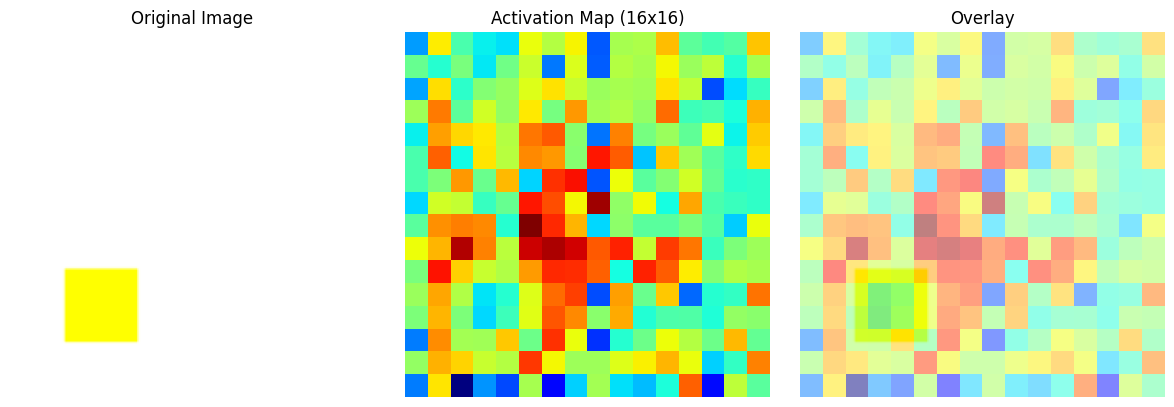

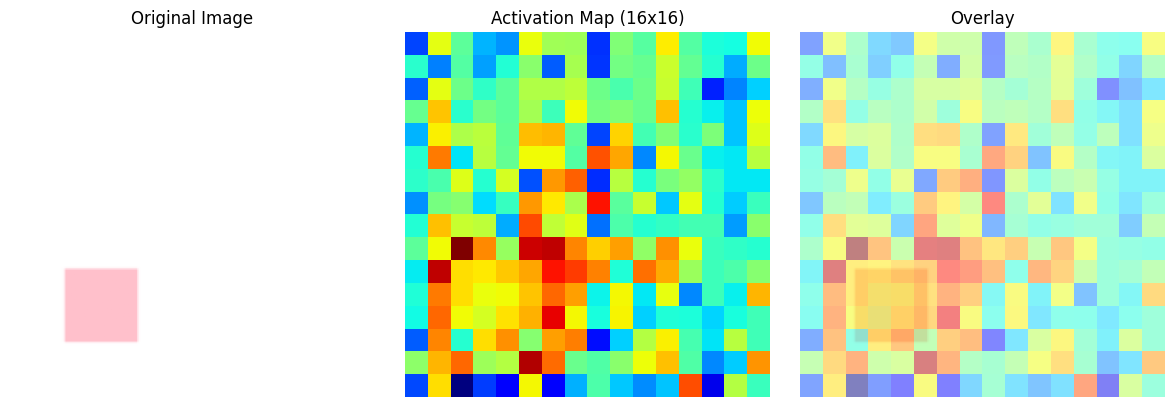

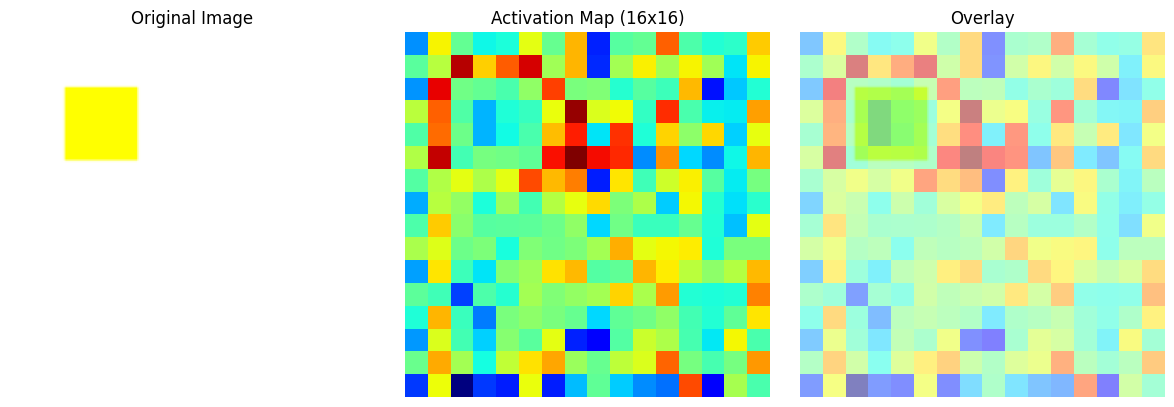

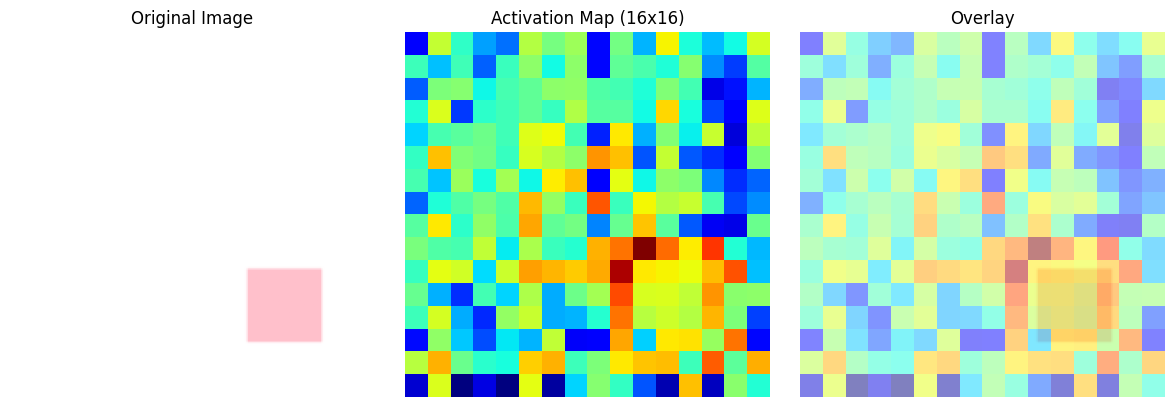

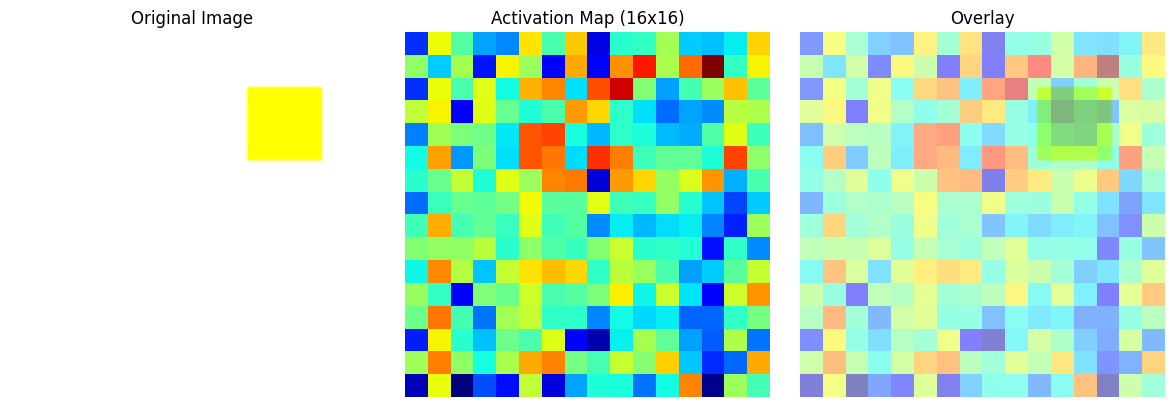

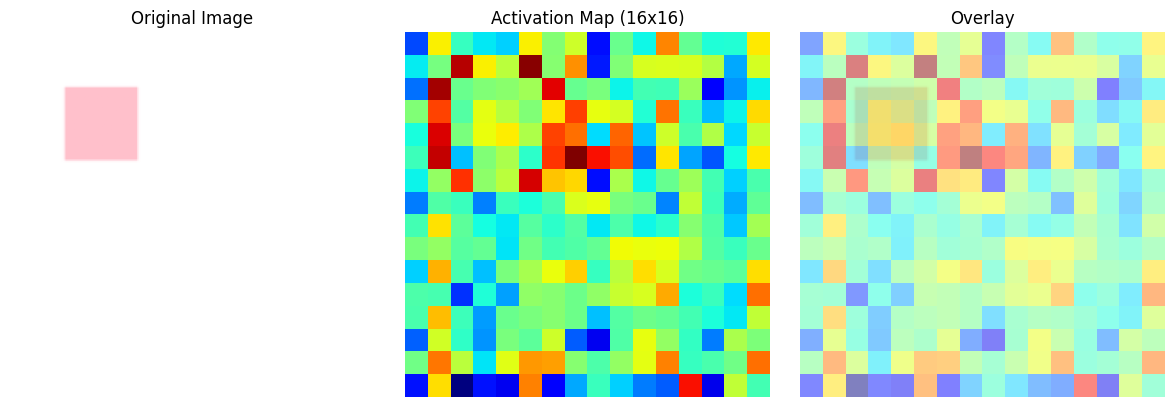

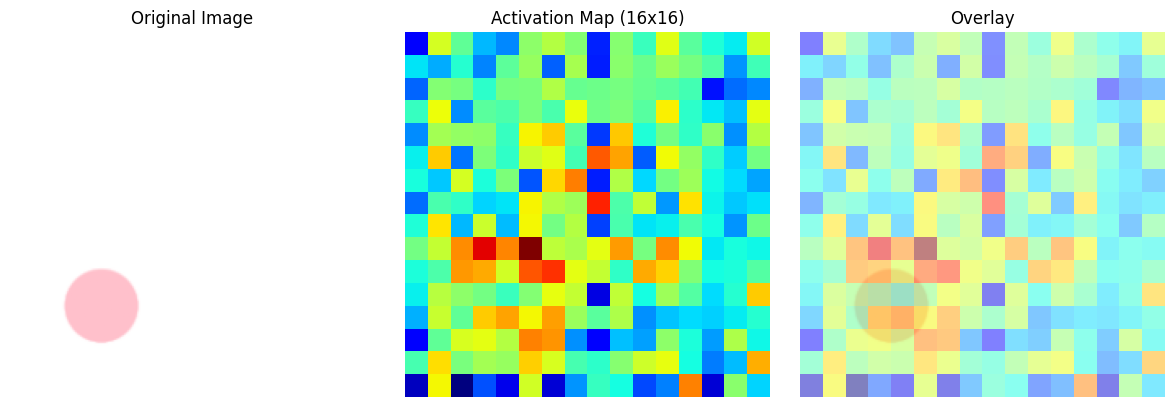

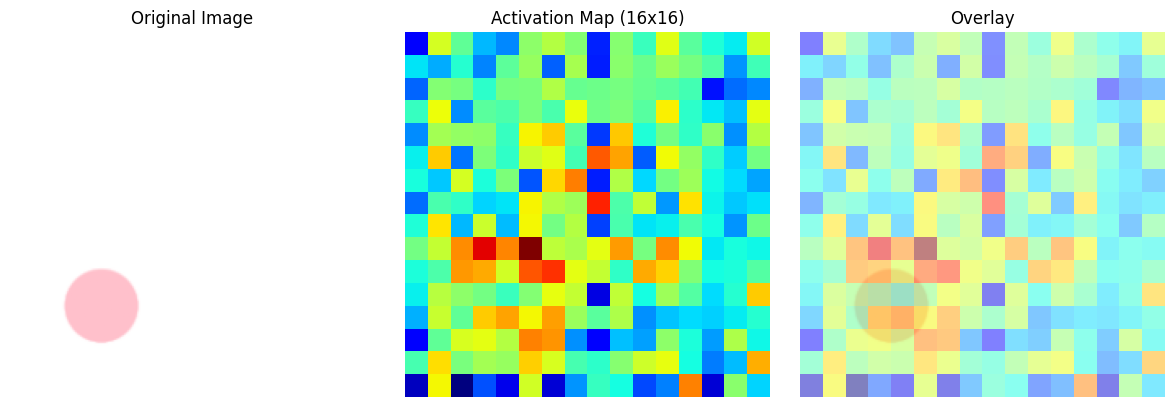

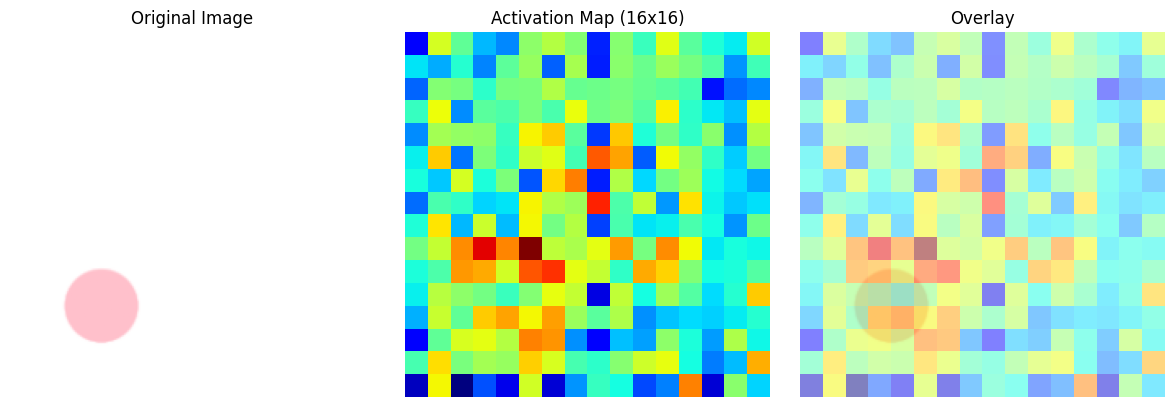

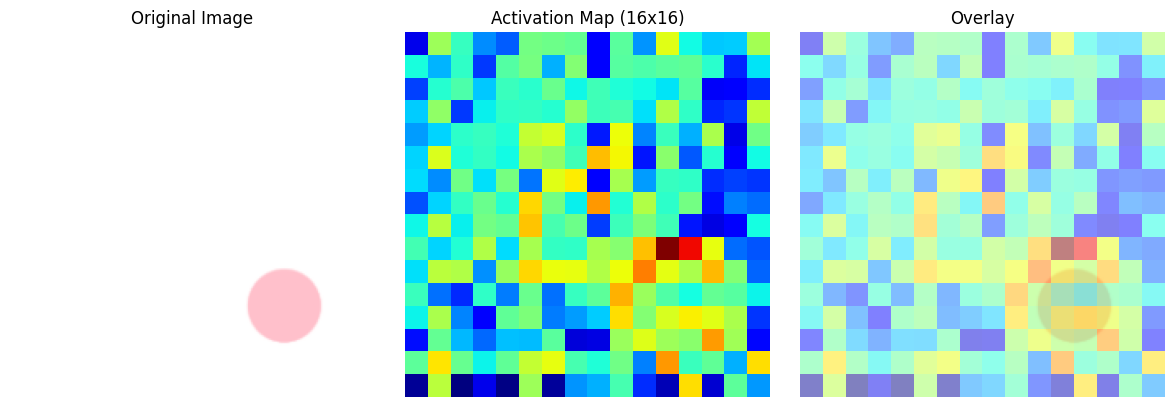

In [17]:
print("Plotting images with top activations for neuron: ", neuron_name)
top_k_images = 10

activations = activations_df[neuron_name].values
top_activations = heapq.nlargest(top_k_images, enumerate(activations), key=lambda x: x[1])

for i, _ in top_activations:
    file_name = activations_df.iloc[i]['filename']
    # image_data = data_df.loc[file_name]

    image = Image.open(file_name)
    image = transform(image)
    image = image.unsqueeze(0)

    outputs, cache = model_hooked.run_with_cache(image)

    neuron_activations = cache[f'blocks.{layer_num(neuron_name)}.hook_mlp_out'][0, :, neuron_num(neuron_name)].detach().numpy()

    # drop cls token
    neuron_activations = neuron_activations[1:]

    # reshape into matrix
    num_patches = model_hooked.cfg.image_size // model_hooked.cfg.patch_size
    
    neuron_activations = neuron_activations.reshape((num_patches, num_patches))

    # Create an upsampled version of the activation map that matches image dimensions
    # but preserves the blocky appearance
    patch_size = model_hooked.cfg.patch_size  # typically 16 for ViT
    upsampled_activations = np.repeat(np.repeat(neuron_activations, patch_size, axis=0), patch_size, axis=1)
    
    # Optional: Also show the separate views
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.squeeze().permute(1, 2, 0))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(neuron_activations, cmap='jet')
    axs[1].set_title("Activation Map (16x16)")
    axs[1].axis('off')
    
    axs[2].imshow(image.squeeze().permute(1, 2, 0))
    axs[2].imshow(upsampled_activations, cmap='jet', alpha=0.5, interpolation='nearest')
    axs[2].set_title("Overlay")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

Plotting images with top features for neuron:  mean_14_475
Image Paths:  ['generated_images/image_2_shapes_17.png', 'generated_images/image_2_shapes_26.png', 'generated_images/image_2_shapes_31.png', 'generated_images/image_2_shapes_49.png', 'generated_images/image_2_shapes_67.png', 'generated_images/image_2_shapes_75.png', 'generated_images/image_2_shapes_89.png', 'generated_images/image_3_shapes_3.png', 'generated_images/image_3_shapes_5.png', 'generated_images/image_3_shapes_12.png']


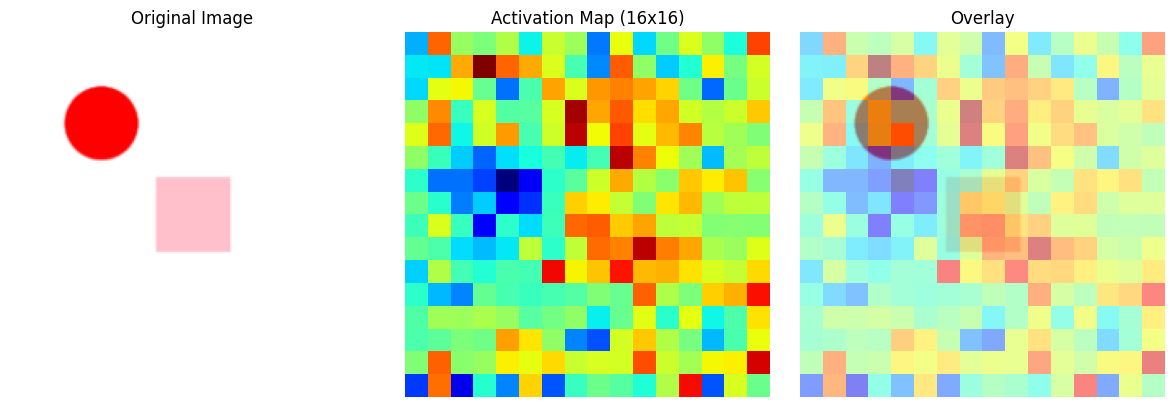

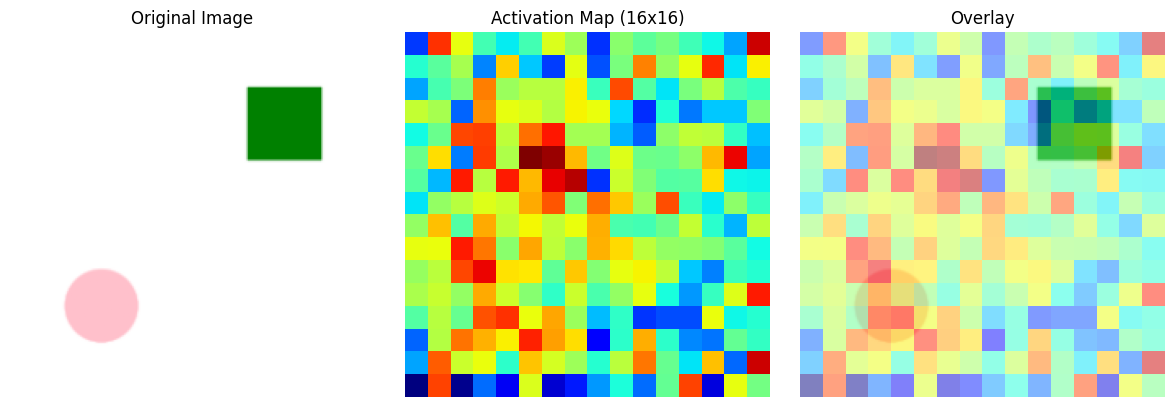

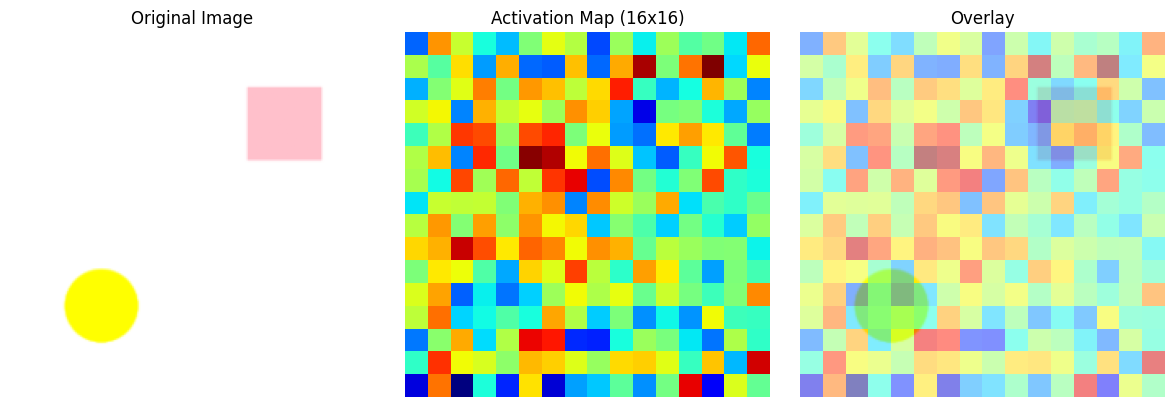

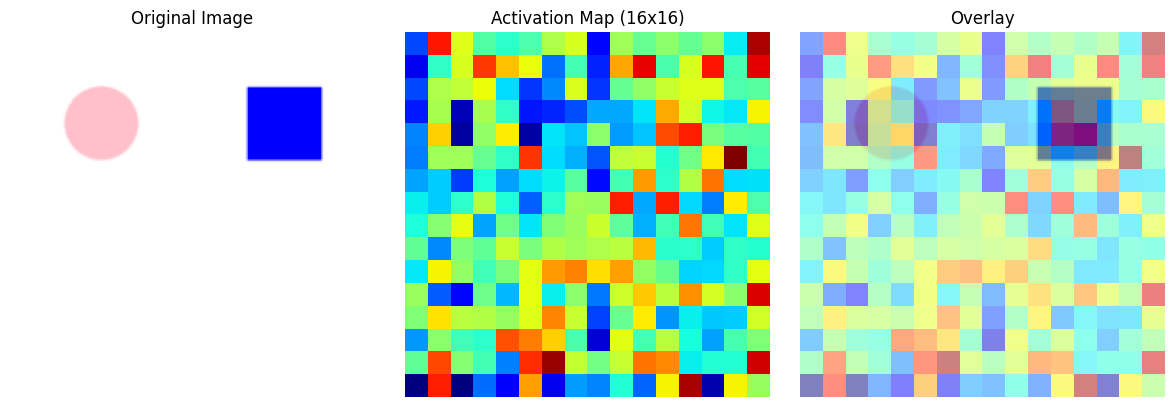

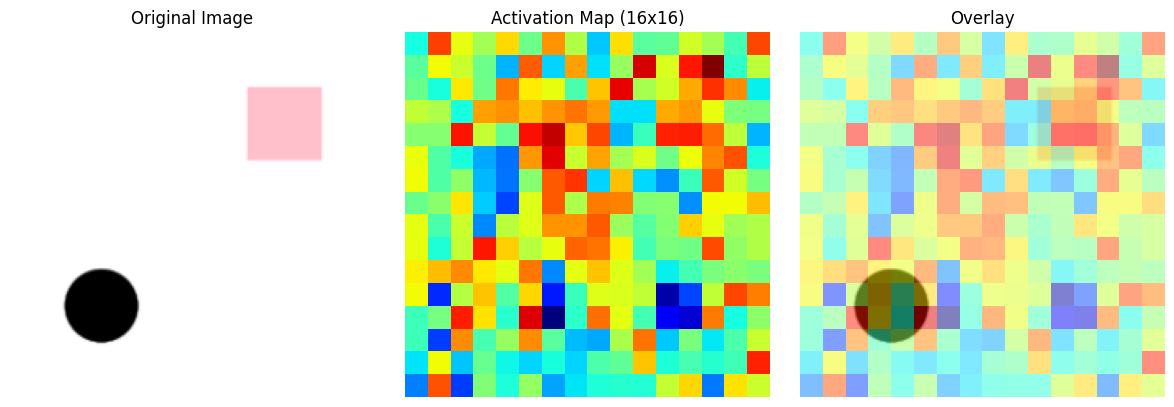

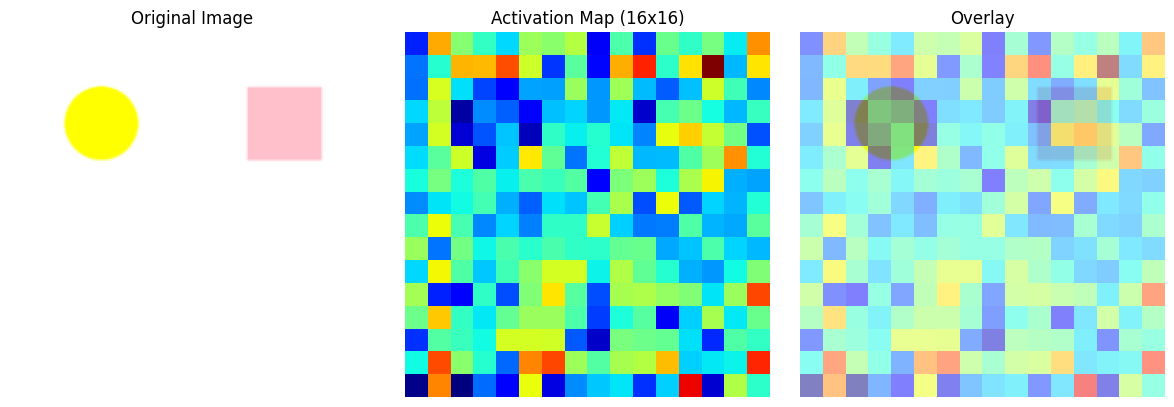

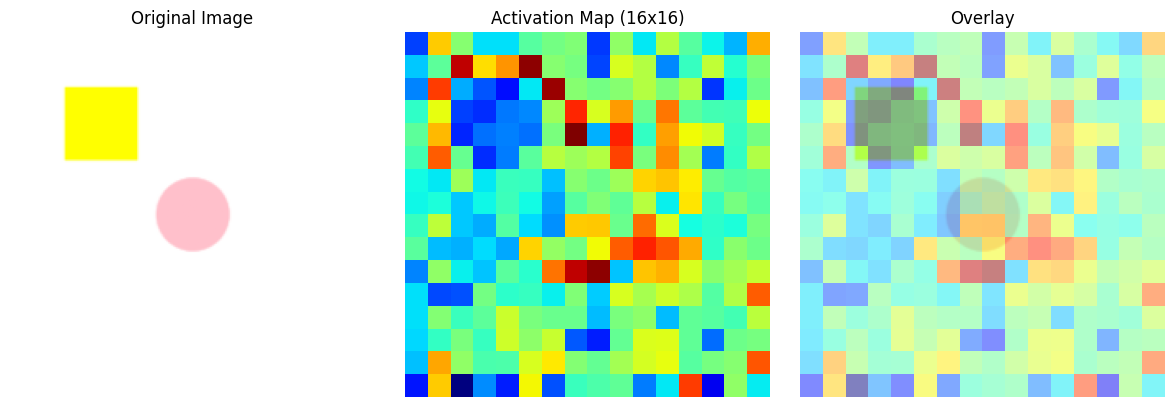

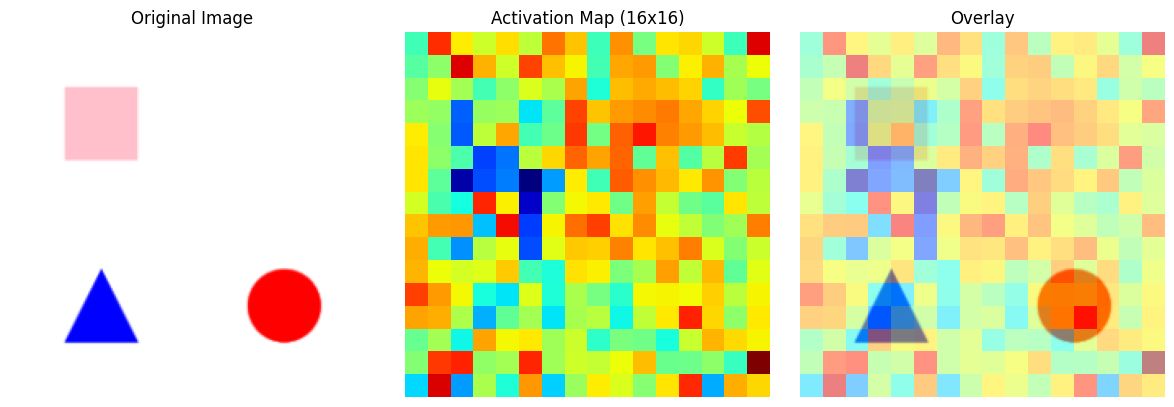

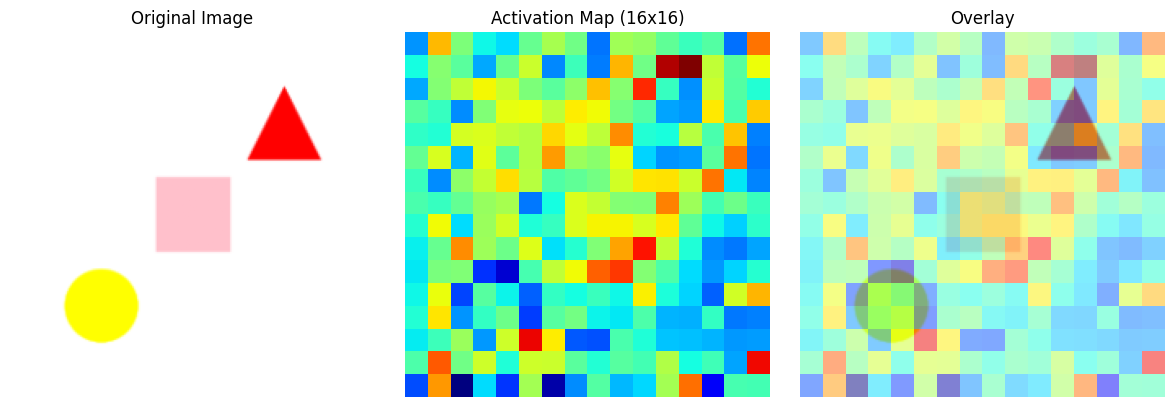

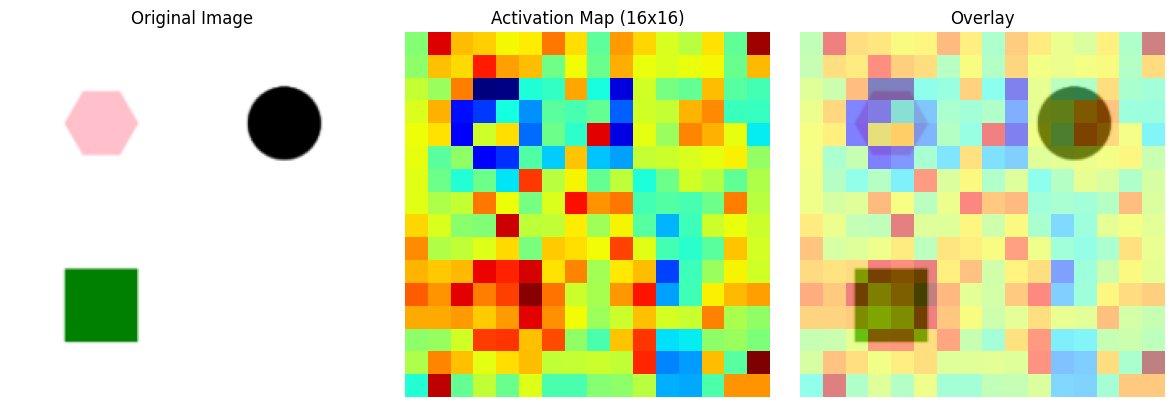

In [18]:
print("Plotting images with top features for neuron: ", neuron_name)
top_k_images = 10
num_top_features = 3

top_k_features = top_features[:num_top_features]

image_paths = get_images_with_given_features(data_df, top_k_features)[:top_k_images]
print("Image Paths: ", image_paths)

for file_name in image_paths:

    image = Image.open(file_name)
    image = transform(image)
    image = image.unsqueeze(0)

    outputs, cache = model_hooked.run_with_cache(image)

    neuron_activations = cache[f'blocks.{layer_num(neuron_name)}.hook_mlp_out'][0, :, neuron_num(neuron_name)].detach().numpy()

    # drop cls token
    neuron_activations = neuron_activations[1:]

    # reshape into matrix
    num_patches = model_hooked.cfg.image_size // model_hooked.cfg.patch_size
    
    neuron_activations = neuron_activations.reshape((num_patches, num_patches))

    # Create an upsampled version of the activation map that matches image dimensions
    # but preserves the blocky appearance
    patch_size = model_hooked.cfg.patch_size  # typically 16 for ViT
    upsampled_activations = np.repeat(np.repeat(neuron_activations, patch_size, axis=0), patch_size, axis=1)
    
    # Optional: Also show the separate views
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.squeeze().permute(1, 2, 0))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(neuron_activations, cmap='jet')
    axs[1].set_title("Activation Map (16x16)")
    axs[1].axis('off')
    
    axs[2].imshow(image.squeeze().permute(1, 2, 0))
    axs[2].imshow(upsampled_activations, cmap='jet', alpha=0.5, interpolation='nearest')
    axs[2].set_title("Overlay")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

Plotting images with top features for neuron:  mean_14_475
Image Paths:  ['generated_images/image_1_shapes_9.png', 'generated_images/image_1_shapes_14.png', 'generated_images/image_1_shapes_25.png', 'generated_images/image_1_shapes_51.png', 'generated_images/image_1_shapes_56.png']


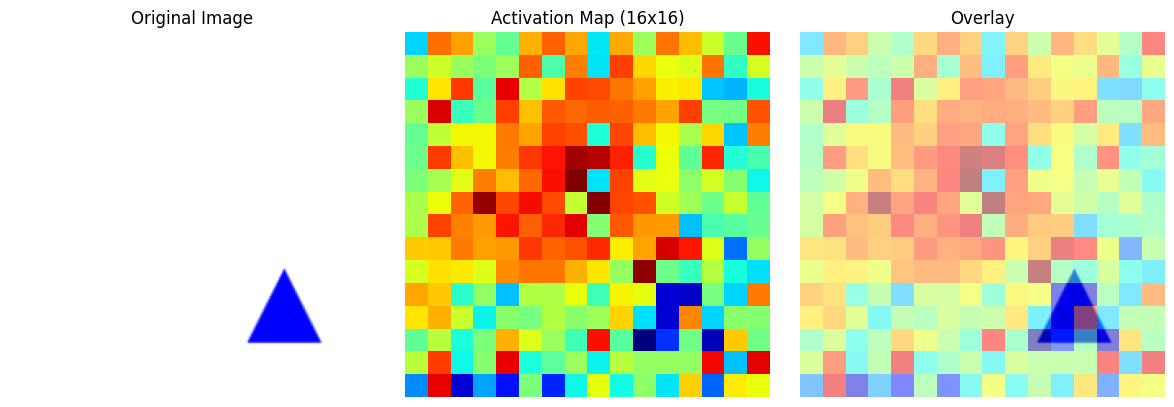

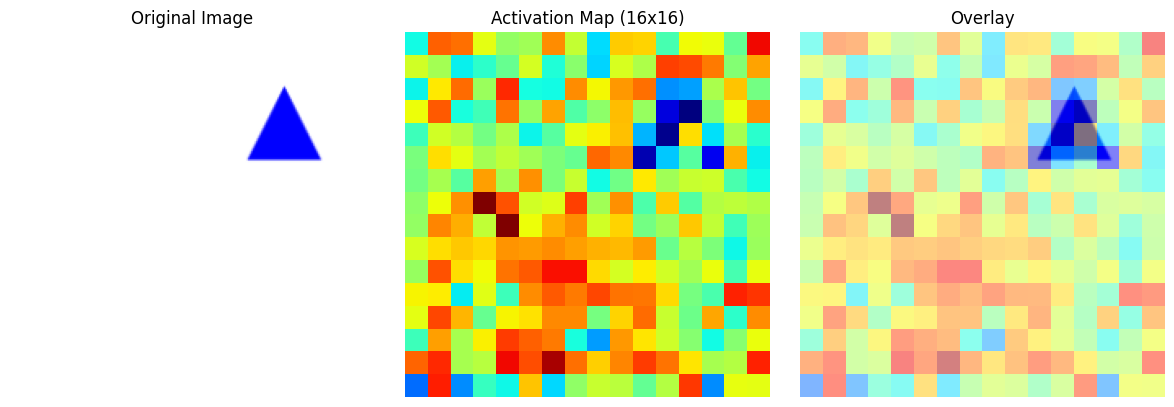

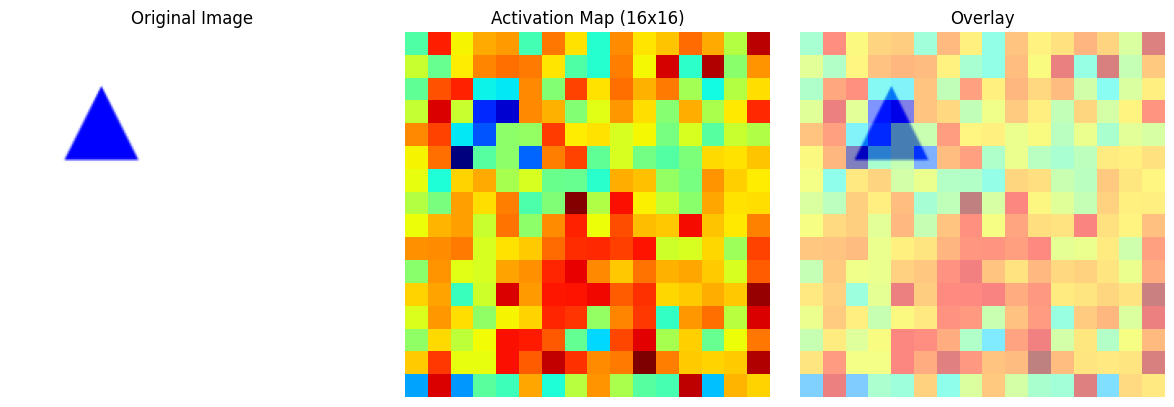

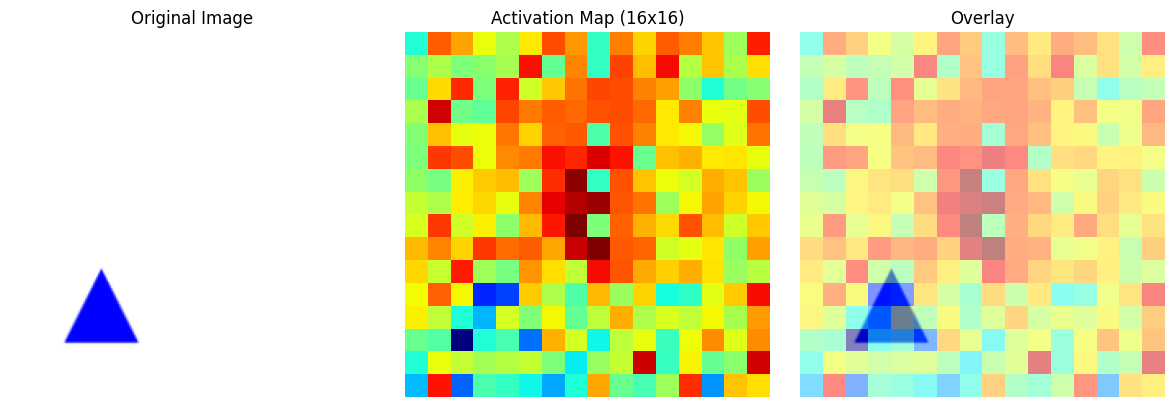

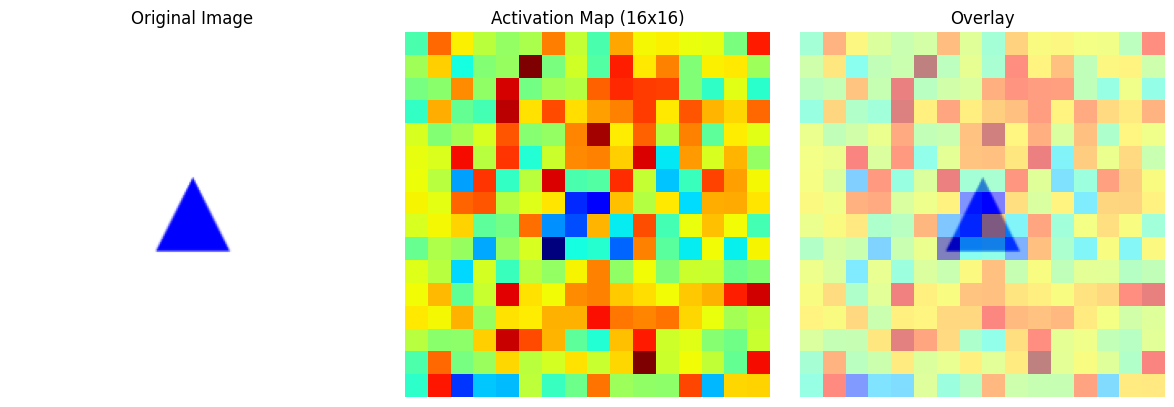

In [19]:
print("Plotting images with top features for neuron: ", neuron_name)
top_k_images = 10
num_top_features = 3

top_k_features = ['blue', 'triangle']

image_paths = get_images_with_given_features(data_df, top_k_features, max_num_shapes=1)[:top_k_images]
print("Image Paths: ", image_paths)

for file_name in image_paths:

    image = Image.open(file_name)
    image = transform(image)
    image = image.unsqueeze(0)

    outputs, cache = model_hooked.run_with_cache(image)

    neuron_activations = cache[f'blocks.{layer_num(neuron_name)}.hook_mlp_out'][0, :, neuron_num(neuron_name)].detach().numpy()

    # drop cls token
    neuron_activations = neuron_activations[1:]

    # reshape into matrix
    num_patches = model_hooked.cfg.image_size // model_hooked.cfg.patch_size
    
    neuron_activations = neuron_activations.reshape((num_patches, num_patches))

    # Create an upsampled version of the activation map that matches image dimensions
    # but preserves the blocky appearance
    patch_size = model_hooked.cfg.patch_size  # typically 16 for ViT
    upsampled_activations = np.repeat(np.repeat(neuron_activations, patch_size, axis=0), patch_size, axis=1)
    
    # Optional: Also show the separate views
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.squeeze().permute(1, 2, 0))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(neuron_activations, cmap='jet')
    axs[1].set_title("Activation Map (16x16)")
    axs[1].axis('off')
    
    axs[2].imshow(image.squeeze().permute(1, 2, 0))
    axs[2].imshow(upsampled_activations, cmap='jet', alpha=0.5, interpolation='nearest')
    axs[2].set_title("Overlay")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

Plotting images with top features for neuron:  mean_14_475
Image Paths:  ['generated_images/image_1_shapes_6.png', 'generated_images/image_1_shapes_15.png', 'generated_images/image_1_shapes_44.png', 'generated_images/image_1_shapes_59.png', 'generated_images/image_1_shapes_74.png', 'generated_images/image_1_shapes_99.png']


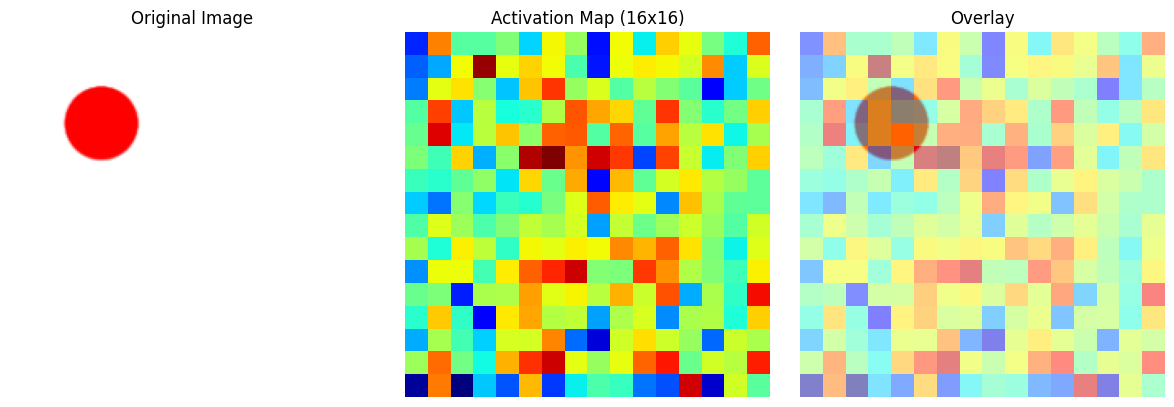

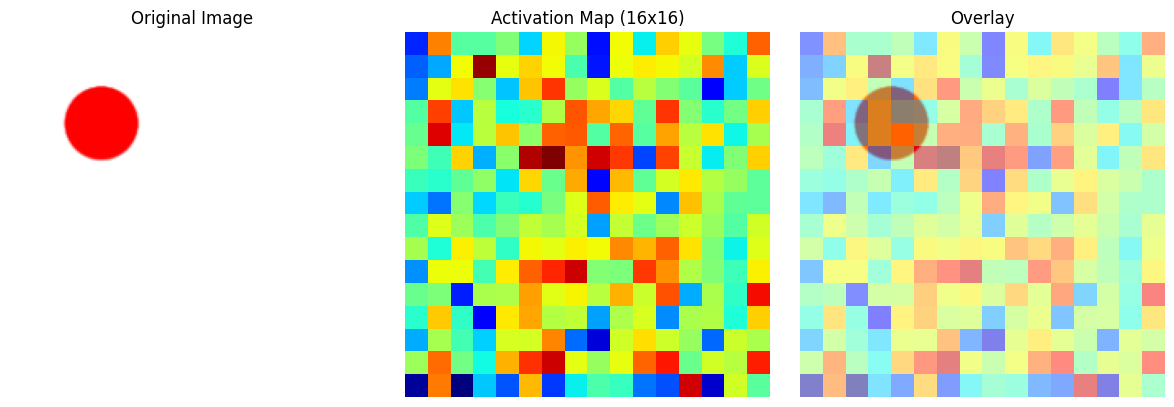

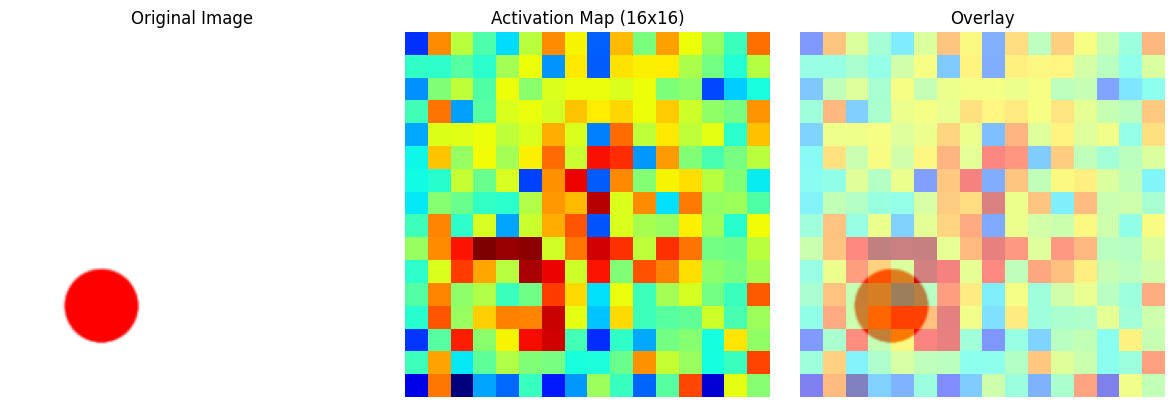

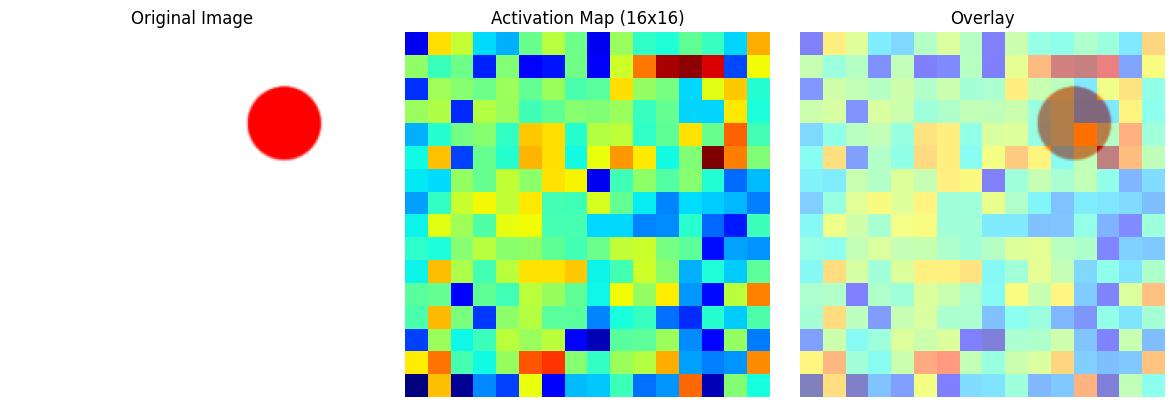

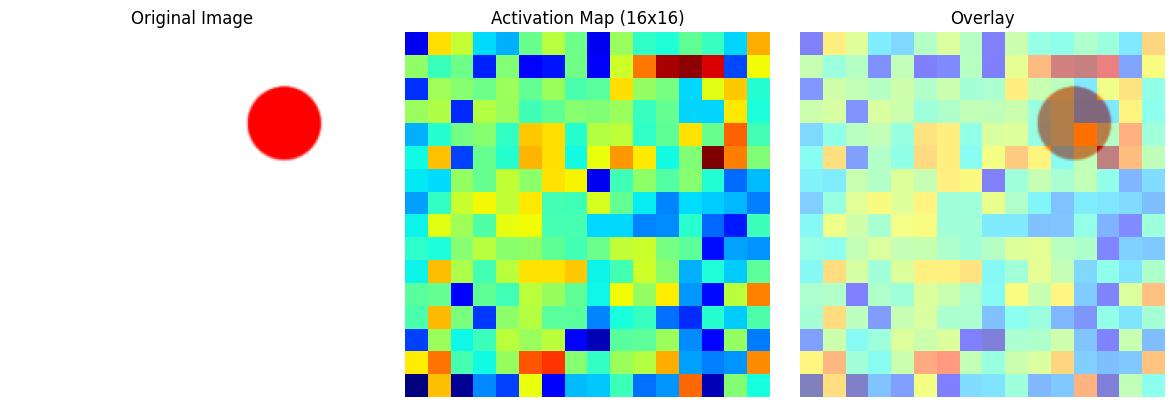

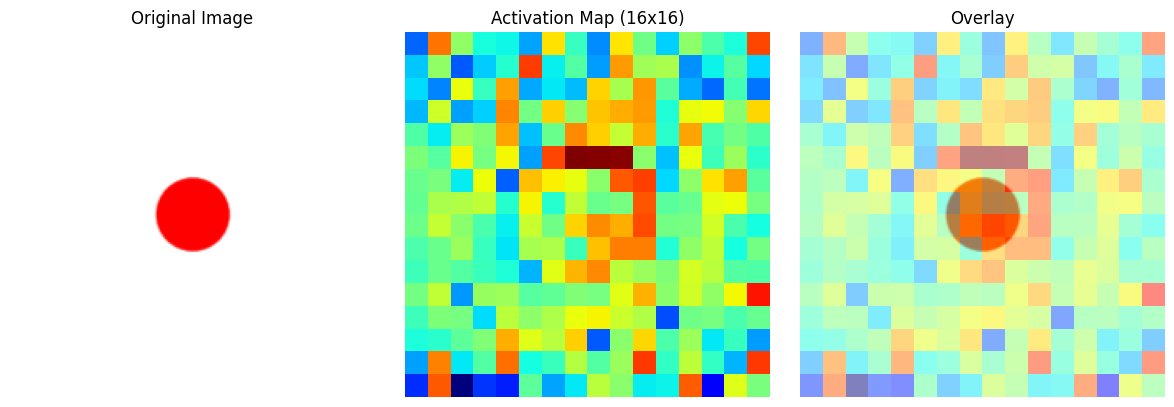

In [20]:
print("Plotting images with top features for neuron: ", neuron_name)
top_k_images = 20
num_top_features = 3

top_k_features = ['red', 'circle']

image_paths = get_images_with_given_features(data_df, top_k_features, max_num_shapes=1)[:top_k_images]
print("Image Paths: ", image_paths)

for file_name in image_paths:

    image = Image.open(file_name)
    image = transform(image)
    image = image.unsqueeze(0)

    outputs, cache = model_hooked.run_with_cache(image)

    neuron_activations = cache[f'blocks.{layer_num(neuron_name)}.hook_mlp_out'][0, :, neuron_num(neuron_name)].detach().numpy()

    # drop cls token
    neuron_activations = neuron_activations[1:]

    # reshape into matrix
    num_patches = model_hooked.cfg.image_size // model_hooked.cfg.patch_size
    
    neuron_activations = neuron_activations.reshape((num_patches, num_patches))

    # Create an upsampled version of the activation map that matches image dimensions
    # but preserves the blocky appearance
    patch_size = model_hooked.cfg.patch_size  # typically 16 for ViT
    upsampled_activations = np.repeat(np.repeat(neuron_activations, patch_size, axis=0), patch_size, axis=1)
    
    # Optional: Also show the separate views
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.squeeze().permute(1, 2, 0))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(neuron_activations, cmap='jet')
    axs[1].set_title("Activation Map (16x16)")
    axs[1].axis('off')
    
    axs[2].imshow(image.squeeze().permute(1, 2, 0))
    axs[2].imshow(upsampled_activations, cmap='jet', alpha=0.5, interpolation='nearest')
    axs[2].set_title("Overlay")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()